In [6]:
!pip install scikit-learn


[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pred_vs_actual(index, y_true, y_pred, model_name, start=None, end=None, save_path=None):
    """
    index     : pandas.DatetimeIndex (or array-like) aligned with y_true/y_pred
    y_true    : 1D array-like of actual values
    y_pred    : 1D array-like of predictions (aligned to y_true)
    model_name: label for the title/legend
    start,end : optional slice to zoom (e.g., '2016-05-10', '2016-05-15' or integer slice)
    save_path : optional path to save the PNG
    """
    
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    dfp = pd.DataFrame({"y_true": y_true, "y_pred": y_pred}, index=index)
    if start is not None or end is not None:
        dfp = dfp.loc[start:end]

    plt.figure(figsize=(12,5))
    plt.plot(dfp.index, dfp["y_true"], label="Actual", alpha=0.9)
    plt.plot(dfp.index, dfp["y_pred"], label=model_name, alpha=0.85)
    plt.title(f"{model_name} — Predicted vs Actual")
    plt.xlabel("Time")
    plt.ylabel("Energy (Appliances)")
    plt.legend()
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=120, bbox_inches="tight")
    plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = pd.read_csv("data/raw/energydata_complete.csv", parse_dates=["date"], skipinitialspace=True)

df["hour"] = df["date"].dt.hour
df["dow"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month

lags = [1, 6, 24, 144]
for L in lags:
    df[f"lag_{L}"] = df["Appliances"].shift(L)

df = df.dropna().reset_index(drop=True)

cols = ["hour", "dow", "month"] + [f"lag_{L}" for L in lags]
X = df[cols]
y = df["Appliances"]

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

naive_pred = y.shift(1).iloc[split:]
mae_naive = mean_absolute_error(y_test, naive_pred)
rmse_naive = np.sqrt(mean_squared_error(y_test, naive_pred))

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

mae_lr = mean_absolute_error(y_test, pred)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred))

print(pd.DataFrame({
    "Model": ["Naive", "Linear Regression"],
    "MAE": [mae_naive, mae_lr],
    "RMSE": [rmse_naive, rmse_lr]
}))


               Model        MAE       RMSE
0              Naive  26.047461  65.185076
1  Linear Regression  25.910229  59.930032


In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

try:
    _ = mae_naive  
except NameError:
    naive_pred = y.shift(1).iloc[split:]
    mae_naive = mean_absolute_error(y_test, naive_pred)
    rmse_naive = np.sqrt(mean_squared_error(y_test, naive_pred))

    mae_lr = mean_absolute_error(y_test, pred)
    rmse_lr = np.sqrt(mean_squared_error(y_test, pred))

scores_path = Path("reports/model_scores.csv")
scores_path.parent.mkdir(parents=True, exist_ok=True)

rows = pd.DataFrame([
    {"model": "Naive",
     "MAE": float(mae_naive),
     "RMSE": float(rmse_naive),
     "MAPE": float(mape(y_test, naive_pred)),
     "n_params": 0},
    {"model": "Linear Regression",
     "MAE": float(mae_lr),
     "RMSE": float(rmse_lr),
     "MAPE": float(mape(y_test, pred)),
     "n_params": int(X_train.shape[1] + 1)} 
])

header = not scores_path.exists()
rows.to_csv(scores_path, mode="a" if not header else "w", header=header, index=False)
rows


,model,MAE,RMSE,MAPE,n_params
0,Naive,26.047461,65.185076,21.864186,0
1,Linear Regression,25.910229,59.930032,24.191032,8


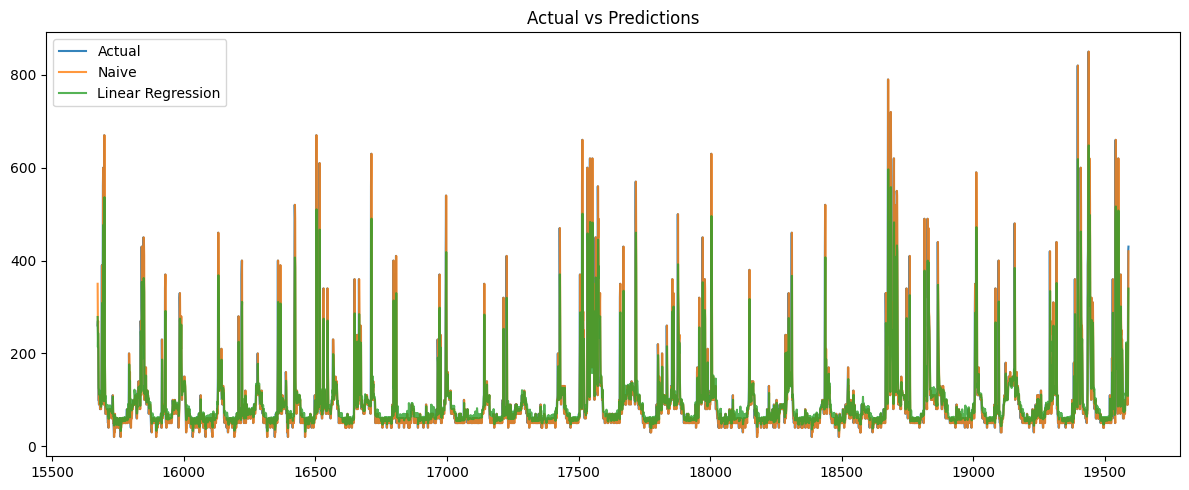

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.9)
plt.plot(y_test.index, naive_pred, label="Naive", alpha=0.8)
plt.plot(y_test.index, pred, label="Linear Regression", alpha=0.8)
plt.title("Actual vs Predictions")
plt.legend()
plt.tight_layout()
plt.show()


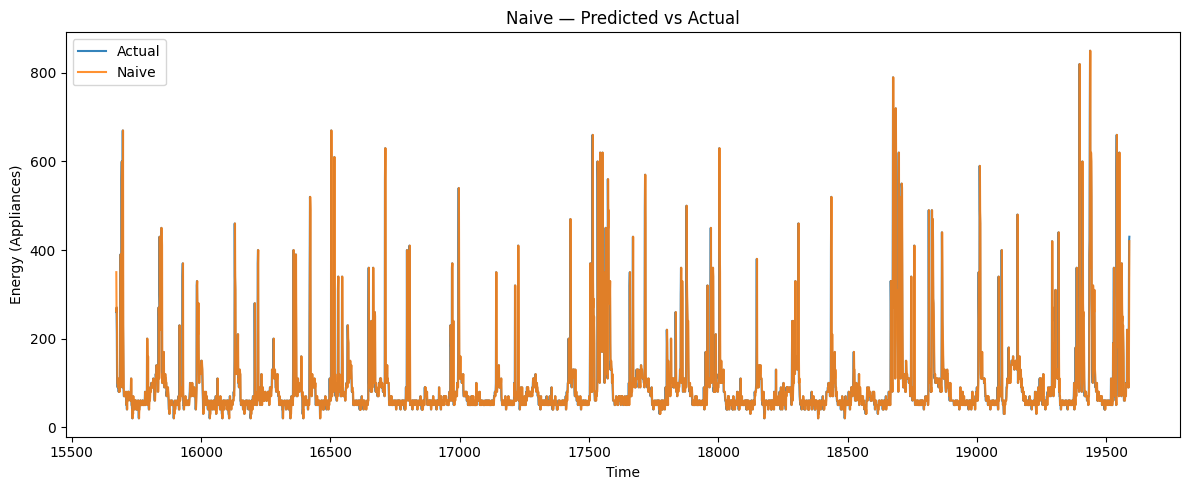

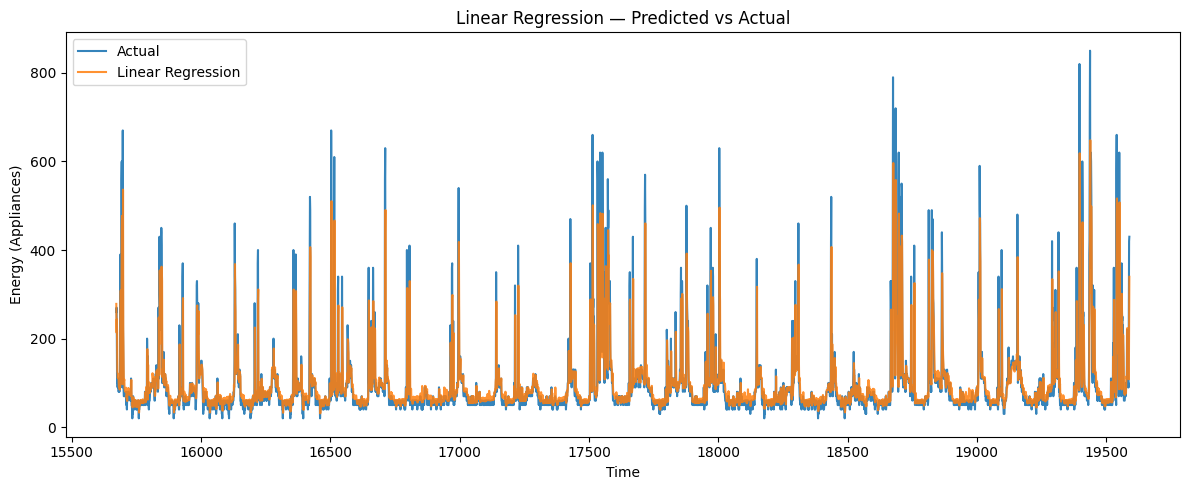

In [9]:

plot_pred_vs_actual(
    index=y_test.index,
    y_true=y_test.values,
    y_pred=naive_pred.values,
    model_name="Naive",
    save_path="reports/figures/naive_pred_vs_actual.png"
)

plot_pred_vs_actual(
    index=y_test.index,
    y_true=y_test.values,
    y_pred=pred, 
    model_name="Linear Regression",
    save_path="reports/figures/lr_pred_vs_actual.png"
)


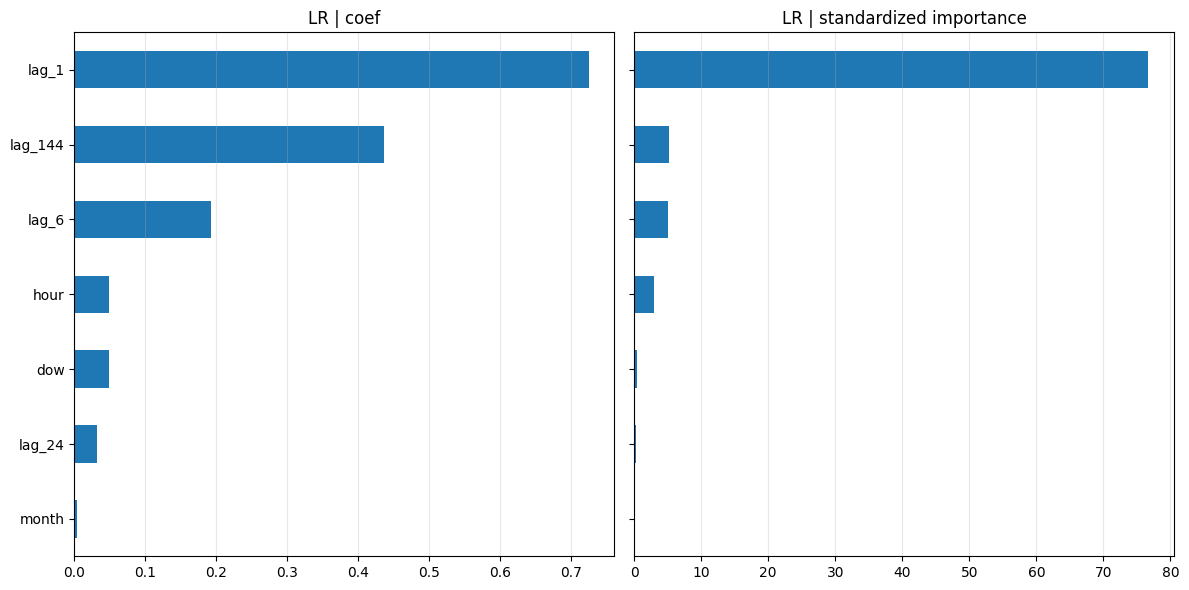

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

coef = pd.Series(model.coef_, index=X_train.columns, name="coef")
imp_abs = coef.abs().sort_values(ascending=True)

stdized = (coef * X_train.std()).abs().sort_values(ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
imp_abs.plot(kind="barh", ax=ax[0], title="LR | coef")
stdized.plot(kind="barh", ax=ax[1], title="LR | standardized importance")
for a in ax: a.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()